In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
def calc_min_interval(x, alpha):
    """Internal method to determine the minimum interval of a given width
    Assumes that x is sorted numpy array.
    """

    n = len(x)
    cred_mass = 1.0-alpha

    interval_idx_inc = int(np.floor(cred_mass*n))
    n_intervals = n - interval_idx_inc
    interval_width = x[interval_idx_inc:] - x[:n_intervals]

    if len(interval_width) == 0:
        raise ValueError('Too few elements for interval calculation')

    min_idx = np.argmin(interval_width)
    hdi_min = x[min_idx]
    hdi_max = x[min_idx+interval_idx_inc]
    return hdi_min, hdi_max


def hpd_single(x, alpha):
    """Calculate highest posterior density (HPD) of array for given alpha. 
    The HPD is the minimum width Bayesian credible interval (BCI).
    :Arguments:
        x : Numpy array
        An array containing MCMC samples
        alpha : float
        Desired probability of type I error (defaults to 0.05)
    """

    # Make a copy of trace
    x = x.copy()
    # For multivariate node
    if x.ndim > 1:
        # Transpose first, then sort
        tx = np.transpose(x, list(range(x.ndim))[1:]+[0])
        dims = np.shape(tx)
        # Container list for intervals
        intervals = np.resize(0.0, dims[:-1]+(2,))

        for index in make_indices(dims[:-1]):
            try:
                index = tuple(index)
            except TypeError:
                pass

            # Sort trace
            sx = np.sort(tx[index])
            # Append to list
            intervals[index] = calc_min_interval(sx, alpha)
        # Transpose back before returning
        return np.array(intervals)
    else:
        # Sort univariate node
        sx = np.sort(x)
        return np.array(calc_min_interval(sx, alpha))
    

([<matplotlib.axis.XTick at 0x7f71c7b7c040>,
 [Text(305, 0, '305'),
  Text(319, 0, '319'),
  Text(334, 0, '334'),
  Text(349, 0, '349'),
  Text(358, 0, '358'),
  Text(365, 0, '365')])

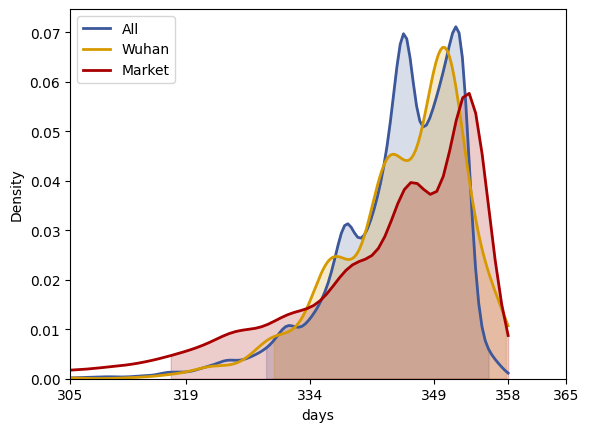

In [9]:
d2 = pd.read_csv('./combined.tMRCA2.csv')
d2['days'] = (d2['tMRCA'] -2019) * 365 + 1 # need the +1, because 2019.0 is day 1

# get 95% HPD for the age(root) of all three datasets
all_95_hpd = hpd_single(d2[d2['analysis'] == 'all']['days'], 0.05)
wuhan_95_hpd = hpd_single(d2[d2['analysis'] == 'wuhan']['days'], 0.05)
market_95_hpd = hpd_single(d2[d2['analysis'] == 'market']['days'], 0.05)

plt.rcParams['svg.fonttype'] = 'none'
fig, ax = plt.subplots(figsize=(6.4, 4.8))
palette = ['#3c589a','#d69a00','#a80000']

sns.kdeplot(data=d2[d2['analysis']=='all'], x="days", common_norm=False, linewidth=2, bw_method='silverman', fill=False, color=palette[0], cut=0, label='All')
sns.kdeplot(data=d2[d2['analysis']=='wuhan'], x="days", common_norm=False, linewidth=2, bw_method='silverman', fill=False, color=palette[1], cut=0, label='Wuhan')
sns.kdeplot(data=d2[d2['analysis']=='market'], x="days", common_norm=False, linewidth=2, bw_method='silverman', fill=False, color=palette[2], cut=0, label='Market')

# fill in 95% HPD for all three datasets
# all data
kde_x, kde_y = ax.lines[0].get_data()
hpd95_start, hpd95_end = False, False
for x in kde_x:
    if x > all_95_hpd[0] and not hpd95_start:
        hpd95_start = x
    if x > all_95_hpd[-1] and not hpd95_end:
        hpd95_end = x
hpd95_start_index = np.where(kde_x == hpd95_start)[0][0]
hpd95_end_index = np.where(kde_x == hpd95_end)[0][0]
ax.fill_between(kde_x[hpd95_start_index:hpd95_end_index+1], kde_y[hpd95_start_index:hpd95_end_index+1], interpolate=False, color=palette[0], alpha = 0.2)

# wuhan data
kde_x, kde_y = ax.lines[1].get_data()
hpd95_start, hpd95_end = False, False
for x in kde_x:
    if x > wuhan_95_hpd[0] and not hpd95_start:
        hpd95_start = x
    if x > wuhan_95_hpd[-1] and not hpd95_end:
        hpd95_end = x
hpd95_start_index = np.where(kde_x == hpd95_start)[0][0]
hpd95_end_index = np.where(kde_x == hpd95_end)[0][0]
ax.fill_between(kde_x[hpd95_start_index:hpd95_end_index+1], kde_y[hpd95_start_index:hpd95_end_index+1], interpolate=False, color=palette[1], alpha = 0.2)

# market data
kde_x, kde_y = ax.lines[2].get_data()
hpd95_start, hpd95_end = False, False
for x in kde_x:
    if x > market_95_hpd[0] and not hpd95_start:
        hpd95_start = x
    if x > market_95_hpd[-1] and not hpd95_end:
        hpd95_end = x
hpd95_start_index = np.where(kde_x == hpd95_start)[0][0]
hpd95_end_index = np.where(kde_x == hpd95_end)[0][0]
ax.fill_between(kde_x[hpd95_start_index:hpd95_end_index+1], kde_y[hpd95_start_index:hpd95_end_index+1], interpolate=False, color=palette[2], alpha = 0.2)

plt.legend()
plt.xlim(305,360)
plt.xticks([305,305+14,305+29,305+44, 305+53, 305+60])
# plt.savefig("tMRCA.svg")

In [10]:
kde_x[hpd95_start_index:hpd95_end_index]

array([317.18570225, 317.97052591, 318.75534956, 319.54017321,
       320.32499687, 321.10982052, 321.89464418, 322.67946783,
       323.46429149, 324.24911514, 325.0339388 , 325.81876245,
       326.60358611, 327.38840976, 328.17323342, 328.95805707,
       329.74288072, 330.52770438, 331.31252803, 332.09735169,
       332.88217534, 333.666999  , 334.45182265, 335.23664631,
       336.02146996, 336.80629362, 337.59111727, 338.37594092,
       339.16076458, 339.94558823, 340.73041189, 341.51523554,
       342.3000592 , 343.08488285, 343.86970651, 344.65453016,
       345.43935382, 346.22417747, 347.00900112, 347.79382478,
       348.57864843, 349.36347209, 350.14829574, 350.9331194 ,
       351.71794305, 352.50276671, 353.28759036, 354.07241402,
       354.85723767, 355.64206132, 356.42688498, 357.21170863])

In [ ]:
, kde_y[hpd95_start_index:hpd95_end_index+1]